In [4]:
from astroML.datasets import generate_mu_z
import matplotlib.pyplot as plt

(35.0, 50.0)

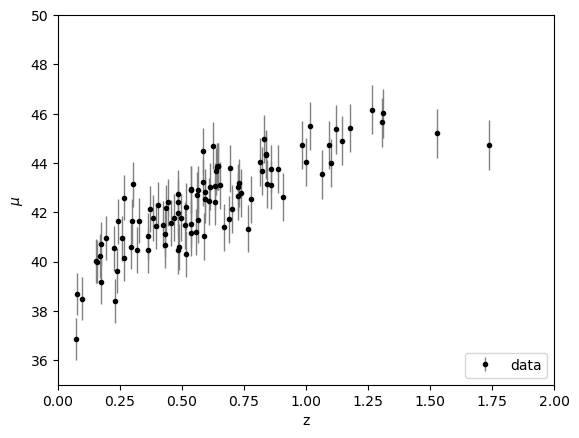

In [5]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

We want to first fit the data both with linear and polinomial regression.

In [6]:
from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression

In [7]:
linear_model = LinearRegression()
linear_model.fit(z_sample, mu_sample, dmu)

print(model.coef_)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [13]:
print(dmu.shape)

(100,)
